In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class MultiClassNetwork:
    
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        self.units = units
        self.batch_size = batch_size
        self.w1 = None
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.a1 = None
        self.losses = []
        self.val_losses = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2
    
    def forpass(self, x):
        
        z1 = np.dot(x, self.w1) + self.b1
        
        self.a1 = self.sigmoid(z1)
        
        z2 = np.dot(self.a1, self.w2) + self.b2
        
        return z2
    
    def backprop(self, x, err):
        
        m = len(x)
        
        dw2 = np.dot(self.a1.T, err) / m
        
        db2 = np.sum(err) / m
        
        # sigmoid 함수의 그라디언트까지 계산
        
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        
        dw1 = np.dot(x.T, err_to_hidden) / m
        
        db1 = np.sum(err_to_hidden, axis=0) / m    
        
        return dw1, db1, dw2, db2
    
    def sigmoid(self, z):
        
        z = np.clip(z, -100, None)
        a = 1 / (1 + np.exp(-z)) # sigmoid
        
        return a
    
    def softmax(self, z):
        
        z = np.clip(z, -100, None)
        
        exp_z = np.exp(z)
        
        return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)
    
    def init_weights(self, n_features, n_classes):

        self.w1 = np.random.normal(0,1, (n_features, self.units))
        
        self.b1 = np.zeros(self.units)
        
        self.w2 = np.random.normal(0,1, (self.units, n_classes))
        
        self.b2 = np.zeros(n_classes)
    
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        
        np.random.seed(42)
        
        self.init_weights(x.shape[1], y.shape[1])
        
        for i in range(epochs):
            
            loss = 0
            
            print('.', end="")
            
            for x_batch, y_batch in self.gen_batch(x,y):
                
                a = self.training(x_batch, y_batch)
                
                a = np.clip(a, 1e-10, 1-1e-10)
                
                loss += np.sum(-y_batch * np.log(a))
                
            
            self.losses.append((loss + self.reg_loss()) / len(x))
            
            self.update_val_loss(x_val, y_val)
            
    def training(self, x, y):
        
        m = len(x)
        
        z = self.forpass(x)
        
        a = self.softmax(z)
        
        err = -(y - a)

        dw1, db1, dw2, db2 = self.backprop(x, err)

        dw1 += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        
        dw2 += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m

        self.w1 -= self.lr * dw1

        self.b1 -= self.lr * db1
        
        self.w2 -= self.lr * dw2

        self.b2 -= self.lr * db2
        
        return a
    
    def predict(self, x):
        z = self.forpass(x)
        
        return np.argmax(z, axis=1)
    
    def score(self, x, y):
        
        return np.mean(self.predict(x) == np.argmax(y, axis=1))
    
    def reg_loss(self):
        
        return self.l1 * (np.sum(np.abs(self.w1)) 
                          + np.sum(np.abs(self.w2))) + self.l2 / 2 * (np.sum(self.w1**2) 
                                                                      + np.sum(self.w2**2))
    
    def update_val_loss(self, x_val, y_val):
        
        z = self.forpass(x_val)
        
        a = self.softmax(z)
        
        a = np.clip(a, 1e-10, 1-1e-10)
        
        val_loss = np.sum(-y_val*np.log(a))
        
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))
        
    def gen_batch(self, x, y):
        
        length = len(x)
        
        bins = length // self.batch_size
        
        if length % self.batch_size:
            bins += 1
        indexes = np.random.permutation(np.arange(len(x)))
        
        x = x[indexes]
        
        y = y[indexes]
        
        for i in range(bins):
            
            start = self.batch_size * i
            
            end = self.batch_size * (i + 1)
            
            yield x[start:end], y[start:end]

In [3]:
import tensorflow as tf

(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


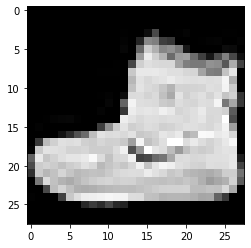

In [5]:
plt.imshow(x_train_all[0], cmap="gray")
plt.show()

In [6]:
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [7]:
np.bincount(y_train_all) # 배열의 정수값의 등장 횟수를 세서 해당하는 인덱스 위치에 저장

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [9]:
np.bincount(y_train)

array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800])

In [10]:
np.bincount(y_val)

array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200])

In [11]:
x_train = x_train / 255
x_val = x_val / 255

In [12]:
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)

In [13]:
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


In [14]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [15]:
print(y_train_encoded.shape, y_val_encoded.shape)

(48000, 10) (12000, 10)


In [16]:
fc = MultiClassNetwork(units=100, batch_size=256)

fc.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=40)

........................................

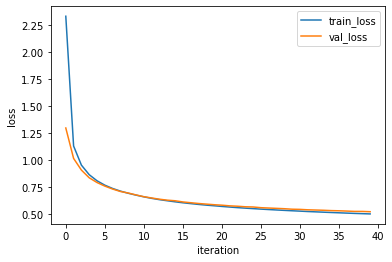

In [17]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel("loss")
plt.xlabel("iteration")
plt.legend(["train_loss", "val_loss"])
plt.show()

In [18]:
fc.score(x_val, y_val_encoded)

0.8150833333333334

In [22]:
# 실행이 안되는 코드?
# w = tf.Variable(tf.zeros(shape=(1)))
# b = tf.Variable(tf.zeros(shape=(1)))

# optimizer = tf.optimizers.SGD(lr = 0.01)

# num_epochs = 10

# for step in range(num_epochs):
    
#     with tf.GradientTape() as tape:
        
#         z_net = w * x_train + b
        
#         z_net = tf.reshape(z_net, [-1])
        
#         sqr_errors = tf.square(y_train - z_net)
        
#         mean_cost = tf.reduce_mean(sqr_errors)
        
#     grads = tape.gradient(mean_cost, [w, b])
    
#     optimizer.apply_gradients(zip(grads, [w,b]))

In [25]:
# tf version 1으로 활성함수조차 포함되어 있지 않는 코드다.
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer="sgd", loss="mse")
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
1500/1500 [==============================] - 9s 5ms/step - loss: nan
Epoch 2/10
1500/1500 [==============================] - 8s 5ms/step - loss: nan
Epoch 3/10
1500/1500 [==============================] - 8s 5ms/step - loss: nan
Epoch 4/10
1500/1500 [==============================] - 8s 5ms/step - loss: nan
Epoch 5/10
1500/1500 [==============================] - 8s 5ms/step - loss: nan
Epoch 6/10
1500/1500 [==============================] - 8s 5ms/step - loss: nan
Epoch 7/10
1500/1500 [==============================] - 8s 5ms/step - loss: nan
Epoch 8/10
1500/1500 [==============================] - 8s 5ms/step - loss: nan
Epoch 9/10
1500/1500 [==============================] - 8s 5ms/step - loss: nan
Epoch 10/10
1500/1500 [==============================] - 8s 5ms/step - loss: nan


In [28]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(100, activation="sigmoid", input_shape=(784,)))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train_encoded, epochs=40, validation_data=(x_val, y_val_encoded))

Epoch 1/40
1500/1500 [==============================] - 18s 12ms/step - loss: 1.3893 - accuracy: 0.6518 - val_loss: 0.9611 - val_accuracy: 0.7368
Epoch 2/40
1500/1500 [==============================] - 18s 12ms/step - loss: 0.8387 - accuracy: 0.7451 - val_loss: 0.7476 - val_accuracy: 0.7628
Epoch 3/40
1500/1500 [==============================] - 18s 12ms/step - loss: 0.7065 - accuracy: 0.7652 - val_loss: 0.6589 - val_accuracy: 0.7796
Epoch 4/40
1500/1500 [==============================] - 18s 12ms/step - loss: 0.6419 - accuracy: 0.7813 - val_loss: 0.6102 - val_accuracy: 0.7872
Epoch 5/40
1500/1500 [==============================] - 18s 12ms/step - loss: 0.6009 - accuracy: 0.7941 - val_loss: 0.5763 - val_accuracy: 0.8010
Epoch 6/40
1500/1500 [==============================] - 18s 12ms/step - loss: 0.5716 - accuracy: 0.8038 - val_loss: 0.5478 - val_accuracy: 0.8102
Epoch 7/40
1500/1500 [==============================] - 18s 12ms/step - loss: 0.5490 - accuracy: 0.8102 - val_loss: 0.5292 -

In [29]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


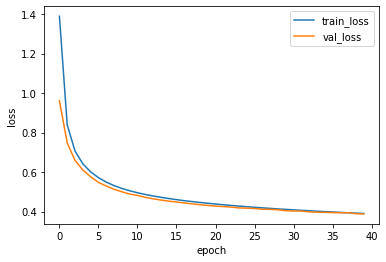

In [30]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "val_loss"])
plt.show()

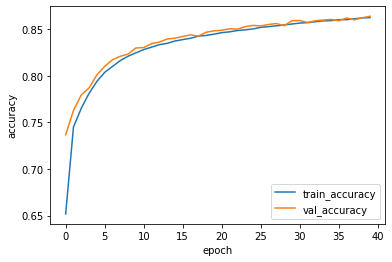

In [31]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

In [33]:
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
print(accuracy)

0.8640833497047424
